In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats

In [12]:
class PairedSimulations():
    def __init__(self, ds_pulse, ds_control):
        self.pulse = ds_pulse
        self.control = ds_control
        self.pulse_response = self.pulse - self.control

In [13]:
ensemble = {source_ID: PairedSimulations(source_ID) for source_IDs}

xarray.core.dataarray.DataArray

In [ ]:
PS = PairedSimulations(ds_pulse, ds_control)

### Data notes
1pct runs are all branched from pictrl (not esm-pictrl); check year of branching

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
model_run_1pct_dict = {
                     'CANESM5_r1p2':'CanESM5_1pctCO2_r1i1p2f1*',
                     'CANESM5_r2p2':'CanESM5_1pctCO2_r2i1p2f1*',
                     'CANESM5_r3p2':'CanESM5_1pctCO2_r3i1p2f1*',
                     'CANESM5_r1p1':'CanESM5_1pctCO2_r1i1p1f1*',
                      'CANESM5_r2p1':'CanESM5_1pctCO2_r2i1p1f1*',
                     'CANESM5_r3p1':'CanESM5_1pctCO2_r3i1p1f1*'}

model_run_control_dict = {
                         'CANESM5_p2':'CanESM5_esm-piControl_r1i1p2f1*',
                          'CANESM5_p1':'CanESM5_esm-piControl_r1i1p1f1*',
                         }

In [8]:
m = 'CANESM5_r1p1'
m_c = 'CANESM5_p1'

In [9]:
ds_control = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_control_dict[m_c]}', preprocess = combined_preprocessing, use_cftime=True)

ds_pulse = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct_dict[m]}', preprocess = combined_preprocessing, use_cftime=True)


In [10]:
ds_control

<xarray.Dataset>
Dimensions:        (time: 12000, y: 64, x: 128, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 5301-01-16 12:00:00 ... 6300-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
  * y              (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(64, 2, 128), meta=np.ndarray>
  * x              (x) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(128, 2, 64), meta=np.ndarray>
    lon            (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
    lat            (x, y) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    height         (time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    tas            (time, y, x) float32 dask.array<chunksize=(1200, 64, 128), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            9c9edd7749a49fec795518842d68bc9e6ef0b60d
    CCCma_parent_runid:          rc3.1-pirlx
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-pifree
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   5301:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/86f84322-8cf1-47f5-bd49-0db9e12...
    variable_id:                 tas
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [11]:
ds_pulse

<xarray.Dataset>
Dimensions:        (time: 1812, y: 64, x: 128, bnds: 2, vertex: 4)
Coordinates:
  * time           (time) object 1850-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1812, 2), meta=np.ndarray>
  * y              (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(64, 2, 128), meta=np.ndarray>
  * x              (x) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(128, 2, 64), meta=np.ndarray>
    lon            (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
    lat            (x, y) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    height         float64 2.0
    tas            (time, y, x) float32 dask.array<chunksize=(1812, 64, 128), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-1ppy
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/3beb38c2-d30a-4ed6-8198-b7b5182...
    variable_id:                 tas
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [31]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [32]:
A = utils.find_area(ds_out)

In [33]:
tas_co2_1pct = {}
tas_co2_pictrl = {}

for m in model_run_1pct_dict.keys():
    print(m)
    print('tas')
    tas_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct_dict[m]}', preprocess = combined_preprocessing, use_cftime=True) #kg/m2/s
    tas_co2_1pct[m] = utils._regrid_ds(tas_co2_1pct[m], ds_out)
for m in model_run_control_dict.keys():
    print(m)
    print('tas')
    tas_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_control_dict[m]}', preprocess = combined_preprocessing, use_cftime=True) #kg/m2/s
    tas_co2_pictrl[m] = utils._regrid_ds(tas_co2_pictrl[m], ds_out)
    if m == 'NORESM2':
        tas_co2_1pct[m]['time'] = tas_co2_pictrl[m]['time'][:1800]

#for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4']:
   # tas_co2_1pct[m]['time'] = tas_co2_pictrl['UKESM1']['time'][:1800]

CANESM5_r1p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [36]:
for m1 in model_run_1pct_dict.keys():
    if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
        m2 = 'CANESM5_p2'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
        m2 = 'CANESM5_p1'
    else:
        m2 = m1
    tas_co2_1pct[m1]['time'] = tas_co2_pictrl[m2]['time'][:len(tas_co2_1pct[m1]['time'])]
    #nbp_1pct[m1]['time'] = nbp_pictrl[m2]['time'][:len(nbp_1pct[m1]['time'])]


In [37]:
dif = {}
for m1 in model_run_1pct_dict.keys():
    if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
        m2 = 'CANESM5_p2'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
        m2 = 'CANESM5_p1'
    else:
        m2 = m1
    dif[m1] = tas_co2_1pct[m1] - tas_co2_pictrl[m2]
    dif[m1] = dif[m1].groupby('time.year').mean()
    dif[m1]['year'] = range(len(dif[m1]['year']))

In [38]:
ds_dif = xr.concat([dif[m] for m in dif.keys()], pd.Index([m for m in dif.keys()], name='model'), coords='minimal')


In [39]:
ds_dif = ds_dif.rename({'year':'s'})

plt.plot(tas_co2_1pct['UKESM1'].weighted(A).mean(dim = ['lat','lon'])['tas']-tas_co2_pictrl['UKESM1'].weighted(A).mean(dim = ['lat','lon'])['tas'])
#plt.xlim(0,50)

plt.plot(tas_co2_1pct['GFDL'].weighted(A).mean(dim = ['lat','lon'])['tas']-tas_co2_pictrl['GFDL'].weighted(A).mean(dim = ['lat','lon'])['tas'])
#plt.xlim(0,50)

anom_dif = (ds_dif.groupby("time.month") - ds_dif.groupby("time.month").mean(dim = 'time'))
anom_dif = anom_dif.groupby('time.year').mean()

anom_base = (ds_base.groupby("time.month") - ds_base.groupby("time.month").mean(dim = 'time'))
anom_1pct = (ds_1pct.groupby("time.month") - ds_1pct.groupby("time.month").mean(dim = 'time'))
anom_dif = anom_1pct - anom_base
anom_dif = anom_dif.groupby('time.year').mean()

In [40]:
G_ds = xr.open_dataset('Outputs/G_canesm5_ds.nc4')['tas']
G_mean_ds = xr.open_dataset('Outputs/G_mean_canesm5_ds.nc4')['tas']

## Linear Regression

In [41]:
G_ds_weighted_mean = G_mean_ds.weighted(A).mean(dim = ['lat','lon']).dropna(dim = 'year')

In [42]:
ds_dif_weighted_mean = ds_dif.weighted(A).mean(dim = ['lat','lon']).dropna(dim = 's')['tas']

def linregress_ds(ds_in, time_var):
    '''Linear regression along a dataarray/dataset variable, returning a new dataset of the same shape. Must select a variable from the dataset or use a data array
    time_var is the name of the time variable (eg: year, time, etc)'''
    ds_linregress = xr.zeros_like(ds_in)
    ds_linregress[time_var] = np.arange(0,len(ds_in[time_var]))
    ds_linregress = ds_linregress.rename({time_var:'time'})
    ds_linregress.time.attrs = {'unit':time_var}
    for t in np.arange(1, len(ds_in[time_var])):
        x = np.arange(0,len(ds_in[time_var]))[:t]
        y = ds_in.values[:t]
        res = stats.linregress(x,y)
        time_var = time_var
        ds_linregress.loc[dict(time = t)] = res.slope
    return(ds_linregress)

ds_dif_regress = linregress_ds(ds_dif_weighted_mean, 'year')

ds_dif_regress.to_netcdf('ds_dif_regress.nc4')

G_linregress = linregress_ds(G_ds_weighted_mean, 'year')

plt.plot(G_linregress)
plt.plot(G_ds_weighted_mean)

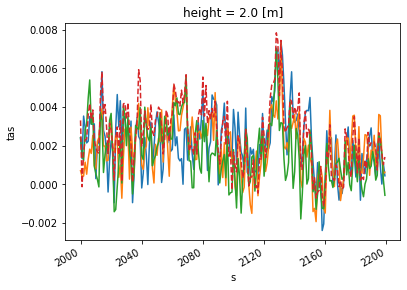

In [59]:
for m in G_ds.model:
    G_ds.weighted(A).mean(dim = ['lat','lon']).dropna(dim = 's').sel(model = m).plot()
G_ds.mean(dim = ['lat','lon']).mean(dim = 'model').plot(linestyle = '--')

## Rolling means

G_10yr_roll_ds = G_ds.rolling(year = 10).mean(center = True).dropna("year")
G_20yr_roll_ds = G_ds.rolling(year = 20).mean(center = True).dropna("year")

G_10yr_mean_roll_ds = G_mean_ds.rolling(year = 10).mean(center = True).dropna("year")
G_20yr_mean_roll_ds = G_mean_ds.rolling(year = 20).mean(center = True).dropna("year")

In [43]:
G_ds = G_ds.rename({'year':'s'})
# G_10yr_roll_ds = G_10yr_roll_ds.rename({'year':'s'})
# G_20yr_roll_ds = G_20yr_roll_ds.rename({'year':'s'})
# #ds_dif = ds_dif.rename({'year':'s'})


In [44]:
G_mean_ds = G_mean_ds.rename({'year':'s'})
# G_10yr_mean_roll_ds = G_10yr_mean_roll_ds.rename({'year':'s'})
# G_20yr_mean_roll_ds = G_20yr_mean_roll_ds.rename({'year':'s'})


## Emissions profile

In [45]:
other_emis = xr.open_dataset(f'1pct_emis_profile_full.nc4').rename({'__xarray_dataarray_variable__':'emis'})

In [46]:
emis_profile = {}
emis_profile['annual'] = xr.open_dataset(f'CanESM5_1pct_emis_profile.nc4')
#emis_profile['annual']['Model_mean'] = emis_profile['annual'].mean()
emis_profile['annual'] = emis_profile['annual'].rename({'__xarray_dataarray_variable__':'emis'})

# emis_profile['10rolling'] = xr.open_dataset(f'1pct_emis_profile_rolling10.nc4')
# #emis_profile['10rolling']['Model_mean'] = emis_profile['10rolling'].groupby('model').mean()
# emis_profile['10rolling'] = emis_profile['10rolling'].rename({'__xarray_dataarray_variable__':'emis'})

# emis_profile['20rolling'] = xr.open_dataset(f'1pct_emis_profile_rolling20.nc4')
# #emis_profile['20rolling']['Model_mean'] = emis_profile['20rolling'].groupby('model').mean()
# emis_profile['20rolling'] = emis_profile['20rolling'].rename({'__xarray_dataarray_variable__':'emis'})

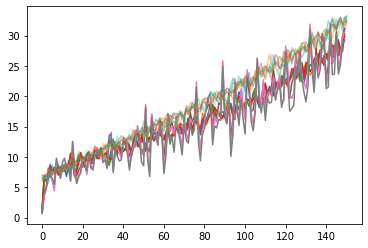

In [21]:
for m in other_emis.model.values:
    plt.plot(other_emis.sel(model = m)['emis'])
for m in emis_profile['annual'].model.values:
    plt.plot(emis_profile['annual'].sel(model = m)['emis'], alpha = .4, label = f'{m}')

## Global Mean Analysis

for m in emis_profile.keys():
    emis_profile[m] = emis_profile[m].where(emis_profile[m].model.isin(['ACCESS','GFDL','NORESM2','MIROC']), drop = True)


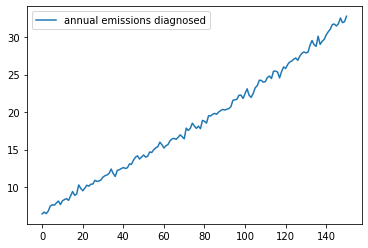

In [22]:
fig, ax = plt.subplots()
for nm in emis_profile.keys():
    plt.plot(emis_profile[nm].mean(dim = 'model')['emis'], label = f'{nm} emissions diagnosed')
plt.legend()
#plt.savefig('figures/1pct_increase/emis_profiles_rolling_means.png', bbox_inches = 'tight', dpi = 350)

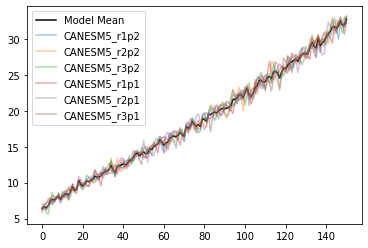

In [23]:
fig, ax = plt.subplots()
plt.plot(emis_profile['annual'].mean(dim = 'model')['emis'], color = 'k', label = f'Model Mean')
for m in emis_profile['annual'].model.values:
    plt.plot(emis_profile['annual'].sel(model = m)['emis'], alpha = .4, label = f'{m}')
plt.legend()
#plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

In [47]:
%%time
ds_GF_mean_dict = {'annual':G_mean_ds.weighted(A).mean(dim = ['lat','lon']), 
              '10rolling':G_10yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon']), 
              '20rolling':G_20yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon'])}
ds_GF_dict = {'annual':G_ds.weighted(A).mean(dim = ['lat','lon']), 
              '10rolling':G_10yr_roll_ds.weighted(A).mean(dim = ['lat','lon']), 
              '20rolling':G_20yr_roll_ds.weighted(A).mean(dim = ['lat','lon'])}
conv_1pct_mean = {}
#linregress_1pct_conv = {}

for nm in ['annual']: 
    print(nm)
    conv_1pct_mean[nm] = {}
    #linregress_1pct_conv[nm] = {}
    print(nm)
    conv_1pct_mean[nm]['mean'] = signal.convolve(np.array(emis_profile[nm].mean(dim = 'model')['emis']), np.array(ds_GF_mean_dict[nm]), 'full')
    conv_1pct_mean[nm]['mean'] = utils.np_to_xr_mean(conv_1pct_mean[nm]['mean'], ds_GF_mean_dict[nm], emis_profile[nm].mean(dim = 'model')['emis'])
    #linregress_1pct_conv[nm]['mean'] = linregress_ds(conv_1pct_mean[nm]['mean'], 's')
    for m1 in emis_profile[nm].model.values:
        if m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r1p1':
            m2 = 'CANESM5_r1'
        elif m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r2p1':
            m2 = 'CANESM5_r2'
        elif m1 == 'CANESM5_r3p2' or m1 == 'CANESM5_r3p1':
            m2 = 'CANESM5_r3'
        conv_1pct_mean[nm][m1] = signal.convolve(np.array(emis_profile[nm].sel(model = m1)['emis']), np.array(ds_GF_dict[nm].sel(model = m2)), 'full')
        conv_1pct_mean[nm][m1] = utils.np_to_xr_mean(conv_1pct_mean[nm][m1], ds_GF_dict[nm].sel(model = m2), emis_profile[nm].sel(model = m1))
        #linregress_1pct_conv[nm][m] = linregress_ds(conv_1pct_mean[nm][m], 's') 

annual
annual
CPU times: user 1.1 s, sys: 483 ms, total: 1.59 s
Wall time: 1.59 s


In [48]:
model_color = {'CANESM5_r1p2':'olive', 'CANESM5_r1p1':'green', 
               'CANESM5_r2p2':'blue', 'CANESM5_r2p1':'lightblue', 
               'CANESM5_r3p2':'purple', 'CANESM5_r3p1':'pink'}


(0.0, 100.0)

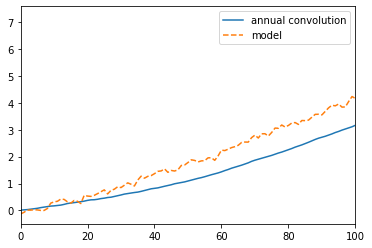

In [26]:
for nm in conv_1pct_mean.keys():
    plt.plot(conv_1pct_mean[nm]['mean'], label = f'{nm} convolution')
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'model', linestyle = '--')
# plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s"), label = '10 rolling model', linestyle = '--')
# plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s"), label = '20 rolling model', linestyle = '--')

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

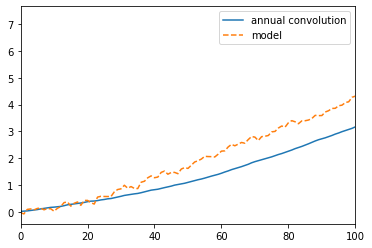

In [49]:
for nm in conv_1pct_mean.keys():
    plt.plot(conv_1pct_mean[nm]['mean'], label = f'{nm} mean convolution')
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'model mean', linestyle = '--')
# plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s"), label = '10 rolling model', linestyle = '--')
# plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s"), label = '20 rolling model', linestyle = '--')

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

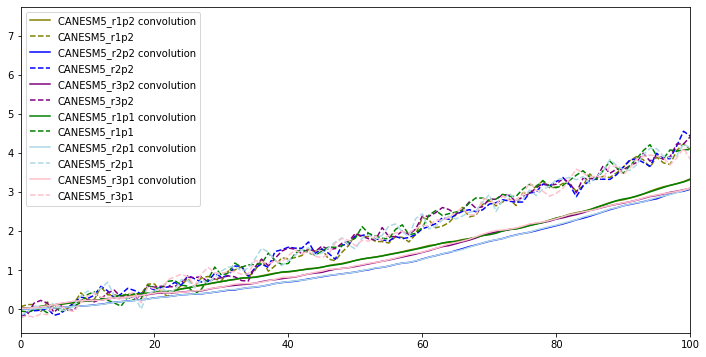

In [27]:
fig, ax = plt.subplots(figsize = [12,6])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', color = model_color[m])
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, linestyle = '--', color = model_color[m])

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

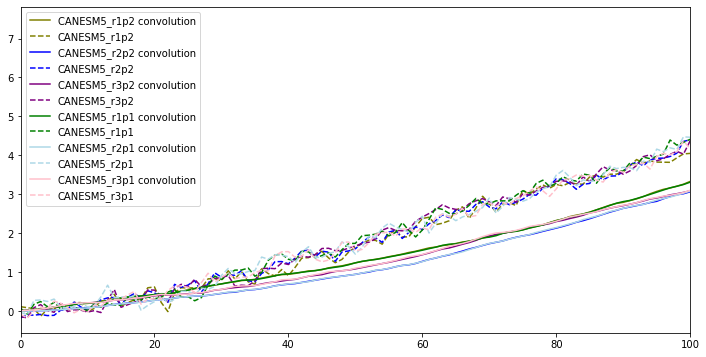

In [50]:
fig, ax = plt.subplots(figsize = [12,6])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', color = model_color[m])
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, linestyle = '--', color = model_color[m])

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

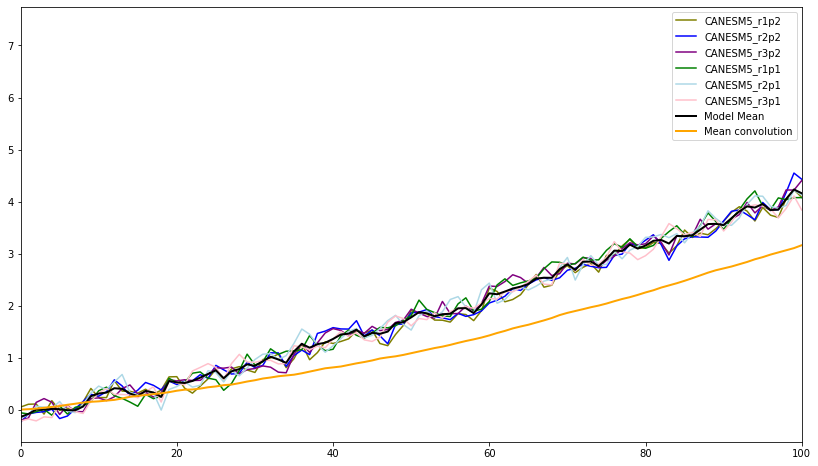

In [28]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k', linewidth = 2)
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_vs_mean_simulation_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

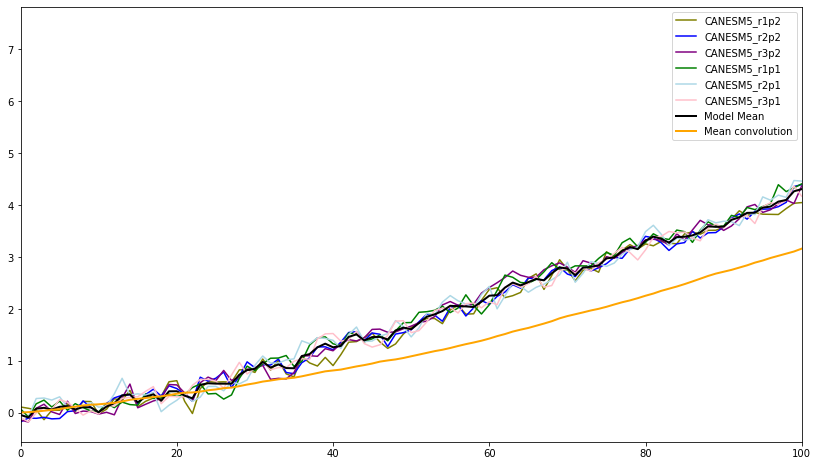

In [51]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k', linewidth = 2)
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_vs_mean_simulation_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

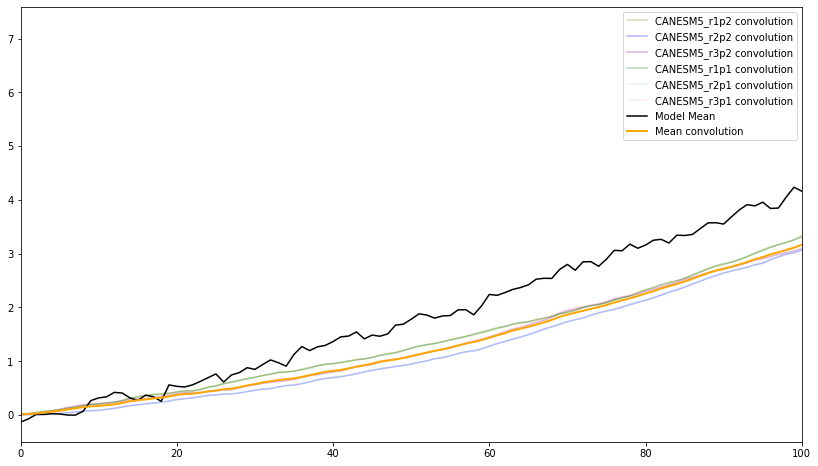

In [29]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', alpha = .3, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k')
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_vs_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


(0.0, 100.0)

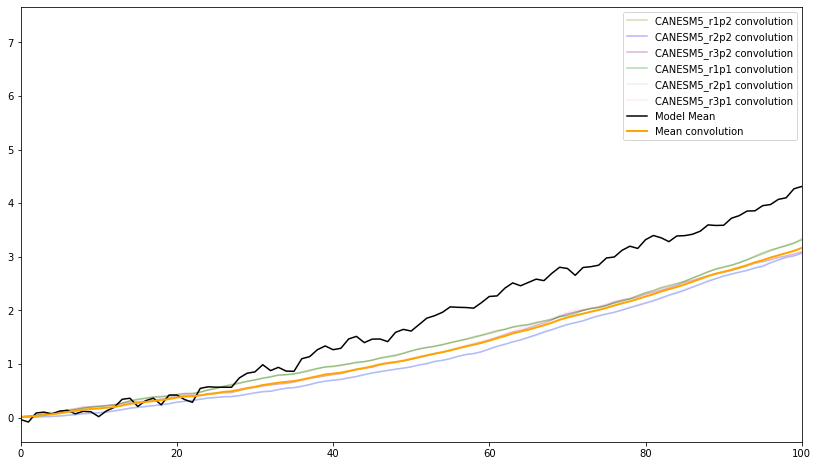

In [52]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', alpha = .3, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k')
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
#plt.savefig('figures/1pct_increase/all_models_vs_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


## without NORESM2 mean

In [66]:
emis_profile['annual'] = emis_profile['annual'].where(emis_profile['annual'].model.isin(['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'GFDL',
       'MIROC', 'ACCESS']), drop = True)

In [67]:
%%time
ds_GF_mean_dict = {'annual':G_mean_ds.weighted(A).mean(dim = ['lat','lon']), 
              '10rolling':G_10yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon']), 
              '20rolling':G_20yr_mean_roll_ds.weighted(A).mean(dim = ['lat','lon'])}
ds_GF_dict = {'annual':G_ds.weighted(A).mean(dim = ['lat','lon']), 
              '10rolling':G_10yr_roll_ds.weighted(A).mean(dim = ['lat','lon']), 
              '20rolling':G_20yr_roll_ds.weighted(A).mean(dim = ['lat','lon'])}
conv_1pct_mean = {}
#linregress_1pct_conv = {}

for nm in ['annual']: 
    print(nm)
    conv_1pct_mean[nm] = {}
    #linregress_1pct_conv[nm] = {}
    print(nm)
    conv_1pct_mean[nm]['mean'] = signal.convolve(np.array(emis_profile[nm].mean(dim = 'model')['emis']), np.array(ds_GF_mean_dict[nm]), 'full')
    conv_1pct_mean[nm]['mean'] = utils.np_to_xr_mean(conv_1pct_mean[nm]['mean'], ds_GF_mean_dict[nm], emis_profile[nm].mean(dim = 'model')['emis'])
    #linregress_1pct_conv[nm]['mean'] = linregress_ds(conv_1pct_mean[nm]['mean'], 's')
    for m1 in emis_profile[nm].model.values:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1'
        else:
            m2 = m1
        conv_1pct_mean[nm][m1] = signal.convolve(np.array(emis_profile[nm].sel(model = m1)['emis']), np.array(ds_GF_dict[nm].sel(model = m2)), 'full')
        conv_1pct_mean[nm][m1] = utils.np_to_xr_mean(conv_1pct_mean[nm][m1], ds_GF_dict[nm].sel(model = m2), emis_profile[nm].sel(model = m1))
        #linregress_1pct_conv[nm][m] = linregress_ds(conv_1pct_mean[nm][m], 's') 

annual
annual
CPU times: user 1.35 s, sys: 417 ms, total: 1.77 s
Wall time: 1.77 s


In [68]:
model_color = {'UKESM1_r1':'olive', 'UKESM1_r2':'brown', 'UKESM1_r3':'green', 'UKESM1_r4':'lightgreen', 'GFDL':'red', 'MIROC':'purple', 'ACCESS':'pink'}


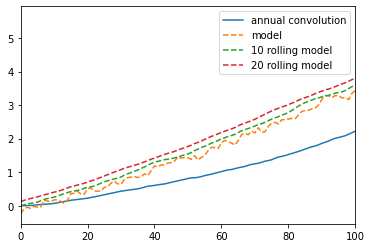

In [69]:
for nm in conv_1pct_mean.keys():
    plt.plot(conv_1pct_mean[nm]['mean'], label = f'{nm} convolution')
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'model', linestyle = '--')
plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 10).mean(center = True).dropna("s"), label = '10 rolling model', linestyle = '--')
plt.plot(np.arange(0,len(ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s")['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'].rolling(s = 20).mean(center = True).dropna("s"), label = '20 rolling model', linestyle = '--')

plt.legend()
plt.xlim(0,100)
plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct_no_NORESM2.png', bbox_inches = 'tight', dpi = 350)


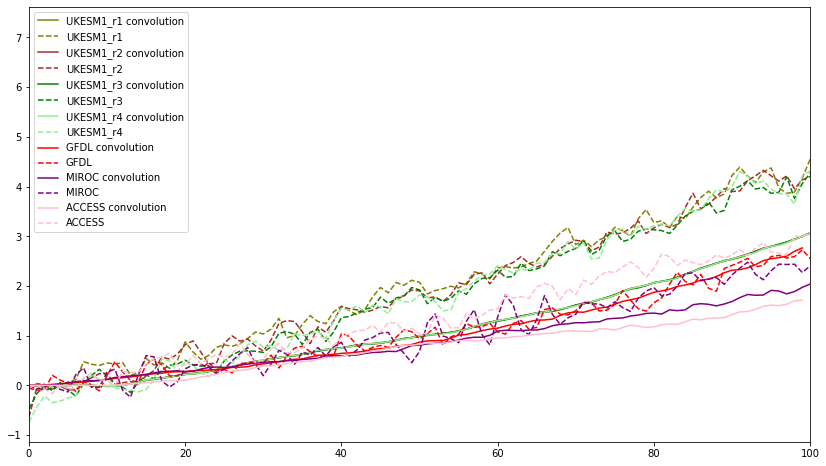

In [70]:
colors = {'UKESM1_r1':'olive', 'UKESM1_r2':'brown', 'UKESM1_r3':'green', 'UKESM1_r4':'lightgreen', 'NORESM2':'blue', 'GFDL':'red', 'MIROC':'purple', 'ACCESS':'pink'}
fig, ax = plt.subplots(figsize = [14,8])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'GFDL', 'MIROC', 'ACCESS']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', color = model_color[m])
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, linestyle = '--', color = model_color[m])

plt.legend()
plt.xlim(0,100)
plt.savefig('figures/1pct_increase/all_models_convolution_vs_1pct_no_NORESM2.png', bbox_inches = 'tight', dpi = 350)


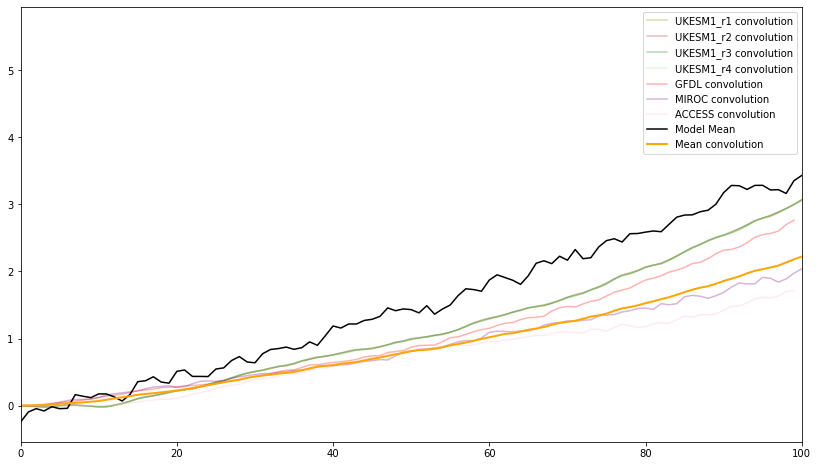

In [71]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'GFDL', 'MIROC', 'ACCESS']:
    plt.plot(conv_1pct_mean['annual'][m], label = f'{m} convolution', alpha = .3, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k')
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
plt.savefig('figures/1pct_increase/all_models_vs_mean_convolution_vs_1pct_no_NORESM2.png', bbox_inches = 'tight', dpi = 350)


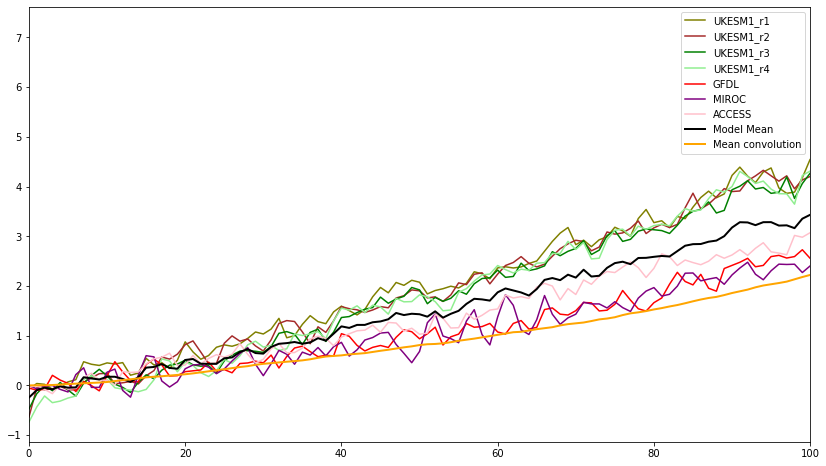

In [73]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'GFDL', 'MIROC', 'ACCESS']:
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, color = model_color[m])
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon','model'])['tas'], label = 'Model Mean', color = 'k', linewidth = 2)
plt.plot(conv_1pct_mean['annual']['mean'], label = f'Mean convolution', color = 'orange', linewidth = 2)

plt.legend()
plt.xlim(0,100)
plt.savefig('figures/1pct_increase/all_models_vs_mean_simulation_vs_1pct_no_NORESM2.png', bbox_inches = 'tight', dpi = 350)


## Linear Regression specific location analysis

In [265]:
loc_dif = {}
loc_1pct = {}

loc_dif_regress = {}
loc_1pct_conv = {}

loc_lat = {'Antarctic':-80,'North America': 40, 'Africa': 20}
loc_lon = {'Antarctic':200, 'North America': 280, 'Africa': 20}


for loc in loc_lat.keys():
    #select location
    loc_dif[loc] = ds_dif.sel(lat = loc_lat[loc], lon = loc_lon[loc], method = 'nearest')['tas']
    loc_1pct[loc] = conv_1pct['annual'].sel(lat = loc_lat[loc], lon = loc_lon[loc], method = 'nearest')
    #regression
    loc_dif_regress[loc] = xr.zeros_like(loc_dif[loc])
    for t in np.arange(1,len(loc_dif[loc].s)):
        reg = loc_dif[loc].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
        loc_dif_regress[loc].loc[dict(s = t)] = reg['polyfit_coefficients'].sel(degree = 1)
    loc_1pct_conv[loc] = xr.zeros_like(loc_1pct[loc])
    for t in np.arange(1,len(loc_1pct[loc].s)):
        reg = loc_1pct[loc].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
        loc_1pct_conv[loc].loc[dict(s = t)] = reg['polyfit_coefficients'].sel(degree = 1)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


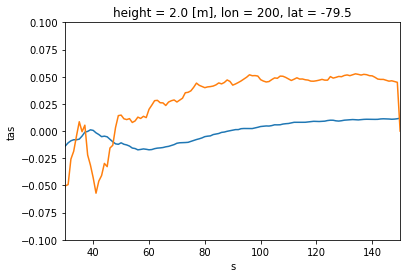

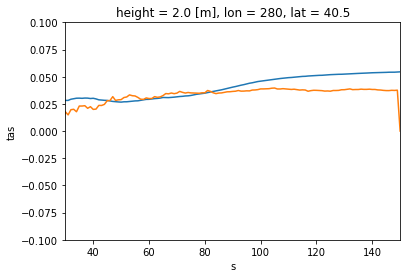

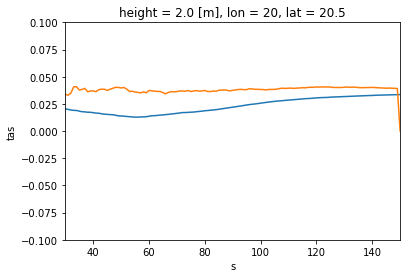

In [275]:
for loc in loc_lat.keys():
    fig, ax = plt.subplots()
    loc_1pct_conv[loc].plot()
    loc_dif_regress[loc].plot()
    plt.ylim(-0.1,0.1)
    plt.xlim(30,150)

## Linear Regression spatial test

In [173]:
linregress_dif = ds_dif.polyfit(dim = 's', deg = 1)

In [224]:
t = 100

In [225]:
test_dif = ds_dif.sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)

In [226]:
test_1pct = conv_1pct['annual'].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)

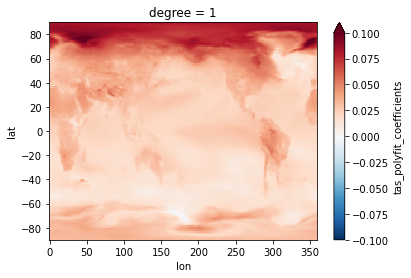

In [282]:
test_dif.sel(degree = 1)['tas_polyfit_coefficients'].plot(vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r')

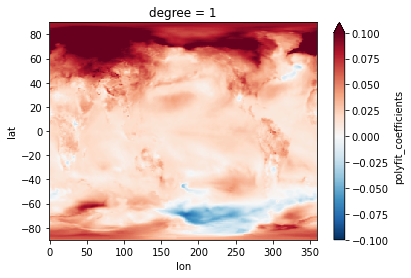

In [283]:
test_1pct.sel(degree = 1)['polyfit_coefficients'].plot(vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r')

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


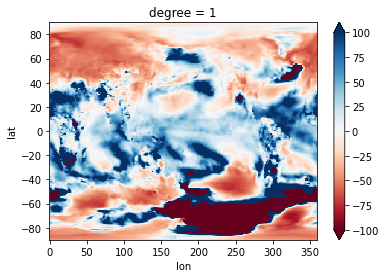

In [236]:
(((test_dif.sel(degree = 1)['tas_polyfit_coefficients']-test_1pct.sel(degree = 1)['polyfit_coefficients'])/
  test_1pct.sel(degree = 1)['polyfit_coefficients'])*100).plot(vmax = 100, vmin = -100, cmap = 'RdBu')

In [234]:
(((test_dif.sel(degree = 1)['tas_polyfit_coefficients']-test_1pct.sel(degree = 1)['polyfit_coefficients'])/test_1pct.sel(degree = 1)['polyfit_coefficients'])*100).mean().values

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array(-6.1056034)

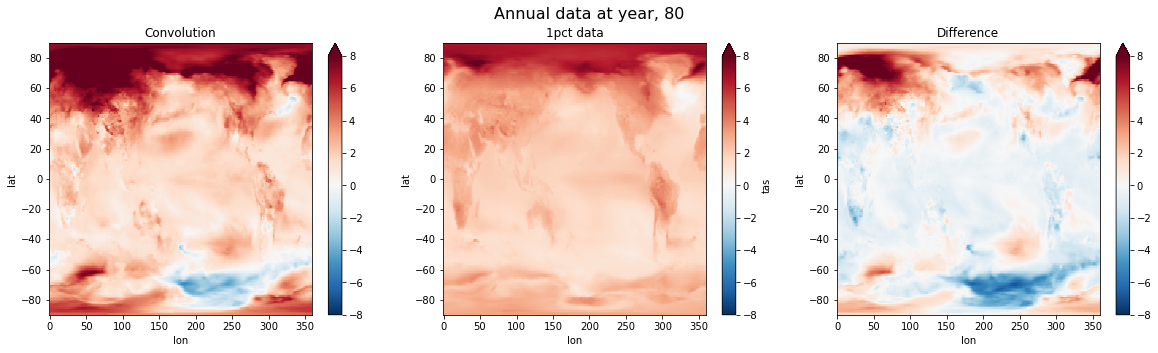

In [228]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['annual'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['annual'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'Annual data at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


In [214]:
linregress_1pct = xr.zeros_like(conv_1pct['annual'])
for t in np.arange(1,len(conv_1pct['annual'].s))[80:]:
    reg = conv_1pct['annual'].sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
    linregress_1pct.loc[dict(s = t)] = reg['tas_polyfit_coefficients'].sel(degree = 1)

KeyboardInterrupt: 

In [ ]:
linregress_dif = xr.zeros_like(ds_dif)
for t in np.arange(1,len(ds_dif.s))[80:]:
    reg = ds_dif.sel(s = slice(0,t)).polyfit(dim = 's', deg = 1)
    linregress_dif.loc[dict(s = t)] = reg['tas_polyfit_coefficients'].sel(degree = 1)

In [ ]:
linregress_dif['tas'].weighted(A).mean(dim = ['lat','lon'])

## Spatial Analysis

In [211]:

ds_GF_dict = {'annual':G_ds,'10rolling':G_10yr_roll_ds, '20rolling':G_20yr_roll_ds}


In [212]:
%%time
conv_1pct = {}
for nm in ds_GF_dict.keys():   
    conv_1pct[nm] = signal.convolve(emis_profile[nm][..., None, None], np.array(ds_GF_dict[nm].sel(model = 'GFDL').fillna(0)), 'full')
    conv_1pct[nm] = utils.np_to_xr(conv_1pct[nm], ds_GF_dict[nm].sel(model = 'GFDL'), emis_profile[nm])

CPU times: user 1.16 s, sys: 604 ms, total: 1.76 s
Wall time: 1.77 s


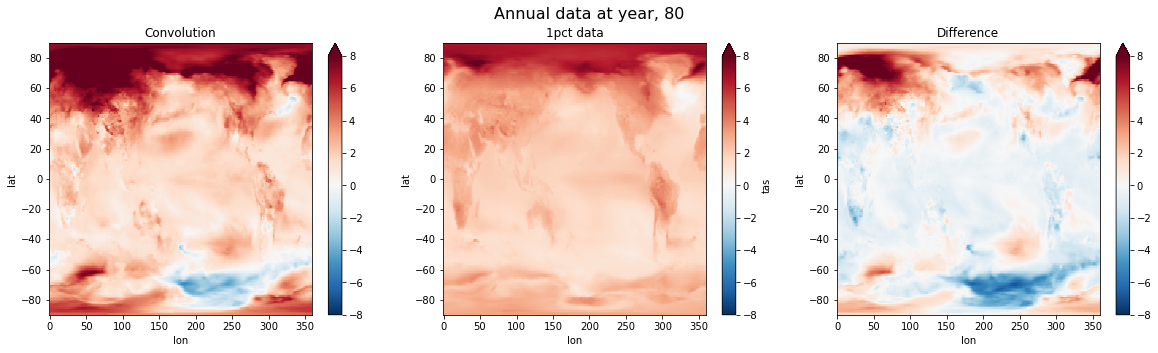

In [32]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['annual'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = slice(t, t+20)).mean('s').plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['annual'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'Annual data at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


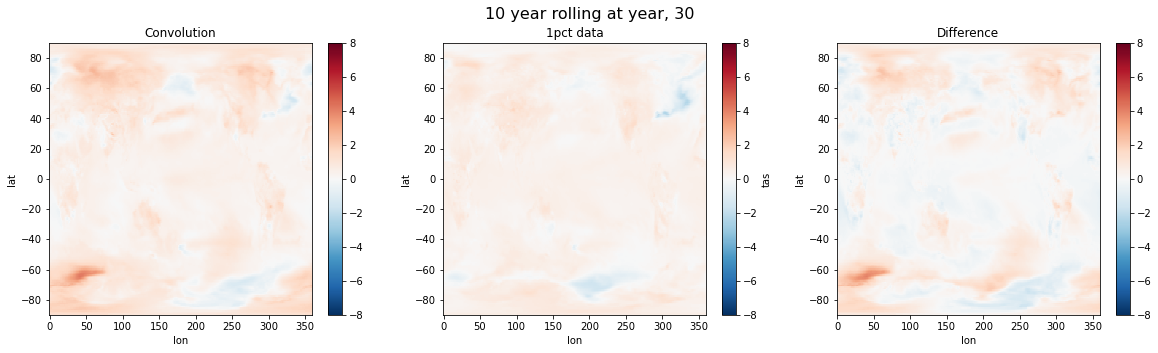

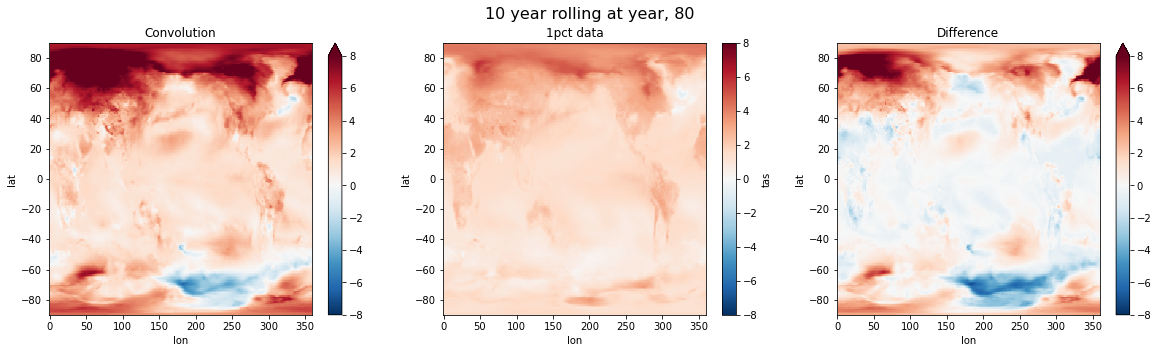

In [30]:
for t in [30, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['10rolling'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].rolling(s = 10).mean('s').dropna('s').sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['10rolling'].sel(s=t) - ds_dif['tas'].rolling(s = 10).mean('s').dropna('s')).sel(s = t).plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'10 year rolling at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


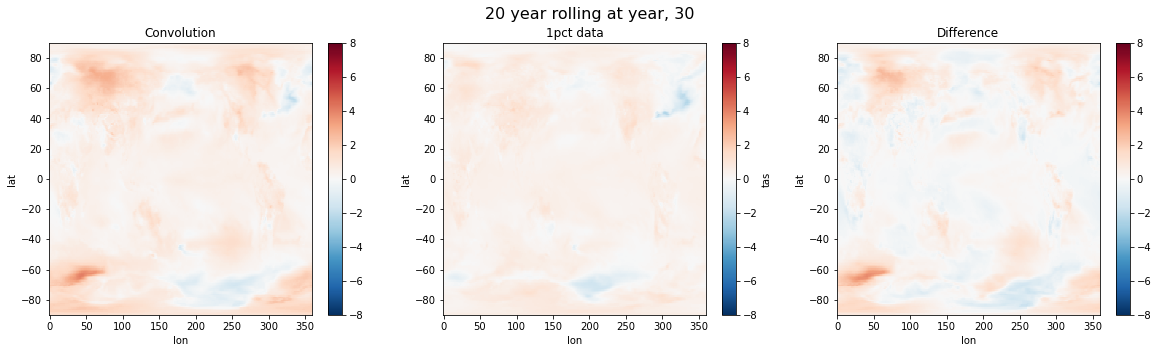

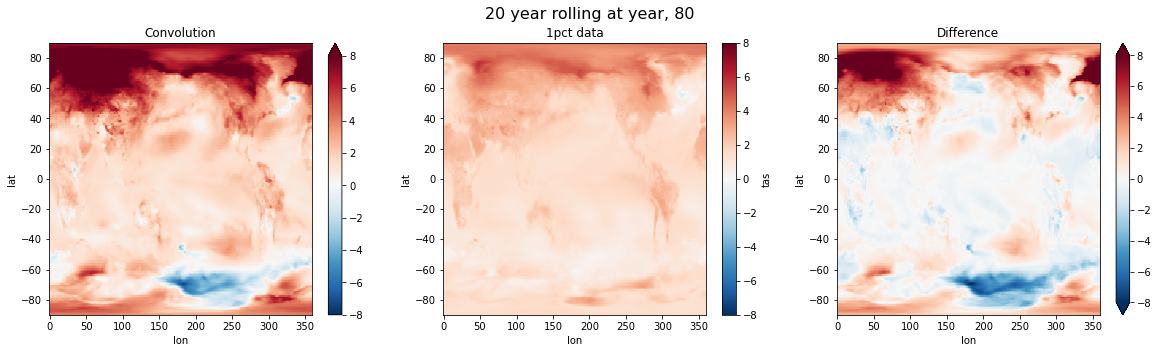

In [31]:
for t in [30, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['20rolling'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].rolling(s = 10).mean('s').dropna('s').sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['20rolling'].sel(s=t) - ds_dif['tas'].rolling(s = 10).mean('s').dropna('s')).sel(s = t).plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(f'20 year rolling at year, {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


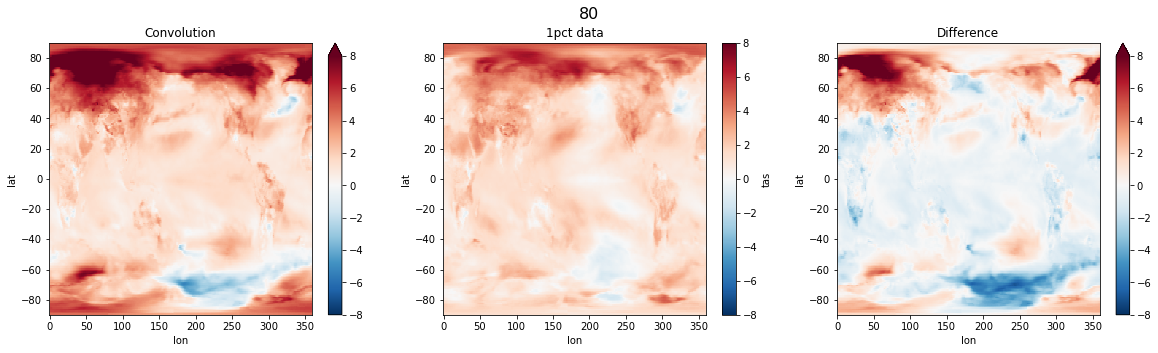

In [23]:
for t in [80]:#, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = t).plot(ax = ax2, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = slice(t, t+20)).mean('s').plot(ax = ax3, vmax = 8, vmin = -8, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(t, fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


## Group base by month 

## Test the start date of our difference

In [24]:
ds_base2 = ds_base.isel(time = slice(12*100,6000))
ds_base2['time'] = ds_base['time'][:len(ds_base2.time)]

In [25]:
ds_base3 = ds_base.isel(time = slice(12*200,6000))
ds_base3['time'] = ds_base['time'][:len(ds_base3.time)]

In [26]:
ds_dif2 = ds_1pct - ds_base2
ds_dif3 = ds_1pct - ds_base3

In [27]:
ds_dif2 = ds_dif2.groupby('time.year').mean()
ds_dif3 = ds_dif3.groupby('time.year').mean()

In [31]:
ds_dif2 = ds_dif2.rename({'year':'s'})
ds_dif3 = ds_dif3.rename({'year':'s'})

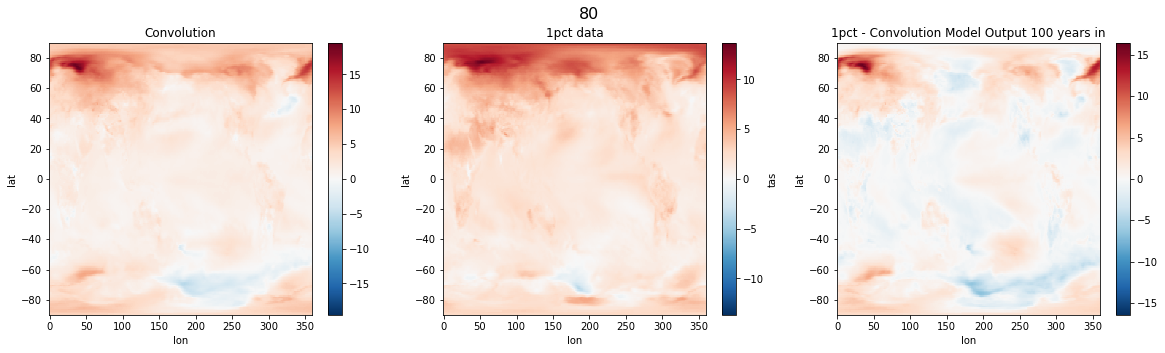

In [32]:
for t in [80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Convolution')
    
    ds_dif2['tas'].sel(s = t).plot(ax = ax2)
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = t).plot(ax = ax3)
    ax3.set_title('1pct - Convolution Model Output 100 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)

In [ ]:
for t in [80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Convolution')
    
    ds_dif2['tas'].sel(s = t).plot(ax = ax2)
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = t).plot(ax = ax3)
    ax3.set_title('1pct - Convolution Model Output 100 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)

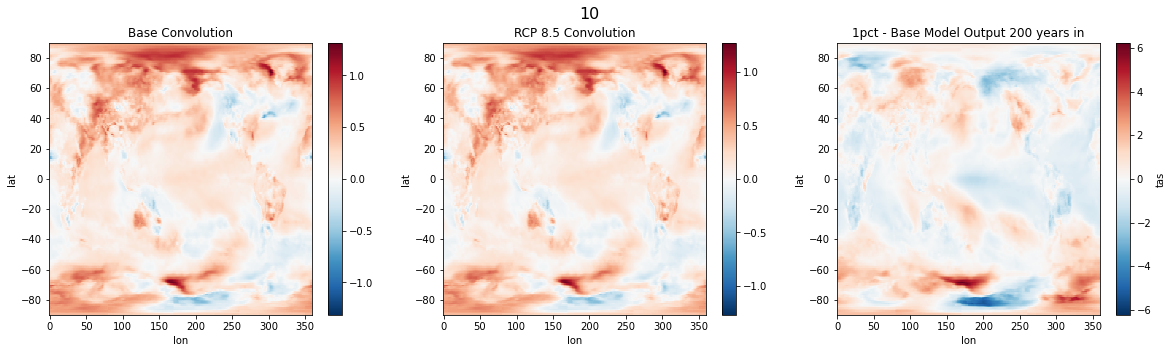

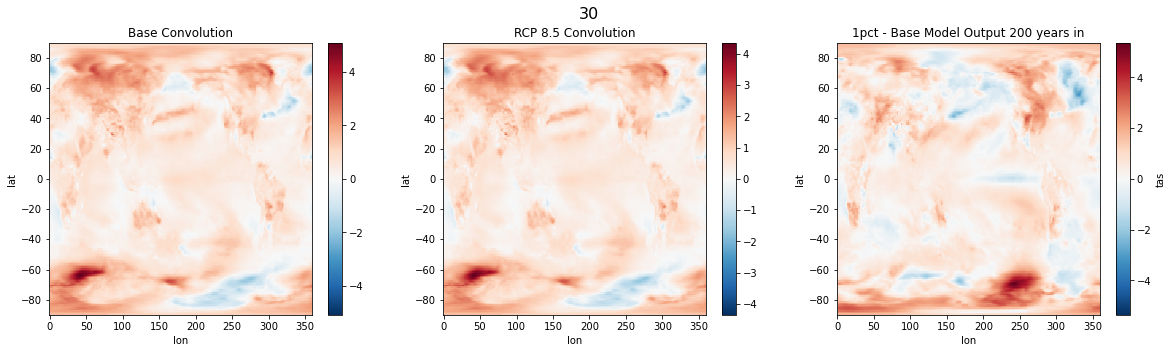

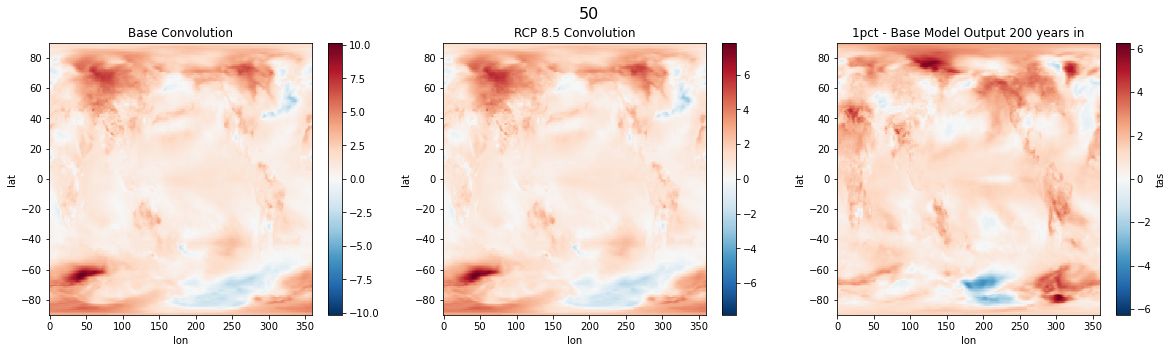

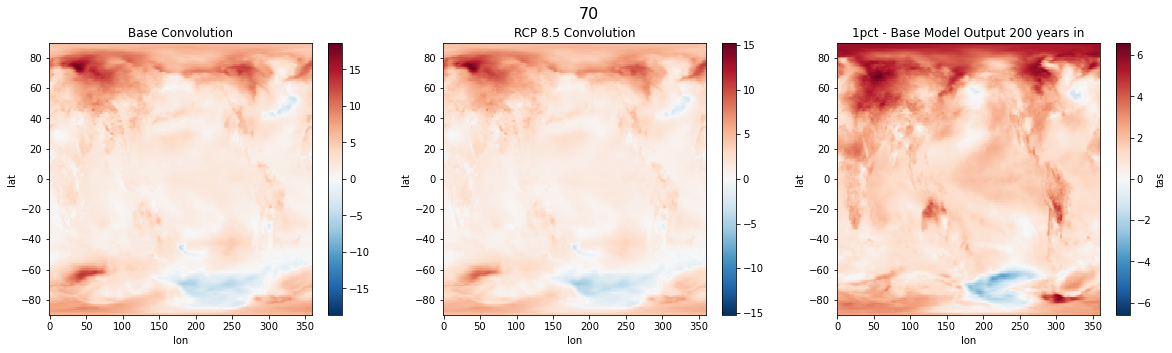

In [123]:
for t in [10,30,50,70]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['base'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Base Convolution')
    
    conv_1pct['rcp85'].sel(s = t).plot(ax = ax2)
    ax2.set_title('RCP 8.5 Convolution')
    
    ds_dif3['tas'].sel(year = t).plot(ax = ax3)
    ax3.set_title('1pct - Base Model Output 200 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)